In [1]:
%matplotlib inline
import matplotlib
import glob
import numpy
import pandas
from sklearn import cluster
from sklearn import decomposition
from sklearn import neighbors
from matplotlib import pyplot
from PIL import Image

#To get the wget use
#!wget --content-disposition --trust-server-names -i urls.txt

In [6]:
images = !find ./images -type f
images = sorted(images)
print("Number of images:", len(images))


Number of images: 375


In [7]:
images[:4]

['./images/1VJ12B004-Q11@12.jpg',
 './images/1VJ12B005-Q11@12.jpg',
 './images/3EM23F00U-Q11@10.jpg',
 './images/4BE23F023-C11@6.jpg']

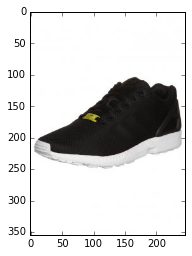

In [13]:
im = [numpy.asarray(Image.open(x)) for x in images]
_ = pyplot.imshow(im[10])

There are several ways of extracting primary colours - we use k-means clustering here. 

In [14]:
flat_individual = [x.reshape(x.shape[0] * x.shape[1], 3) for x in im if len(x.shape) == 3]
def primary_colours(x):
    km = cluster.MiniBatchKMeans(5)
    km.fit(x)
    cc = km.cluster_centers_.copy()
    return cc
features = [primary_colours(x) for x in flat_individual]

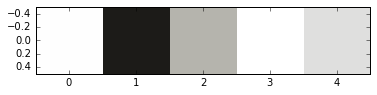

In [16]:
im_0_colours = features[10].reshape(1, 5, 3) / 255
_ = pyplot.imshow(im_0_colours, interpolation='nearest')

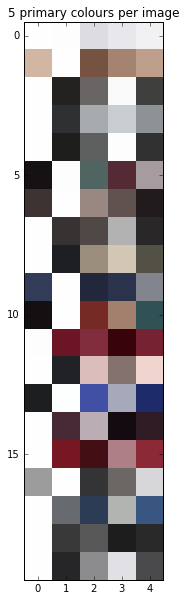

In [17]:
f, ax = pyplot.subplots(1)
f.set_size_inches(10, 10)
ax.set_title('5 primary colours per image')
_ = ax.imshow(numpy.array(features[20:40]).reshape(20, 5, 3) / 255, interpolation='nearest')

In [18]:
nd_features = numpy.array(features)
flat_features = nd_features.reshape(nd_features.shape[0]* nd_features.shape[1], 3)

In [19]:
nns = neighbors.NearestNeighbors(5).fit(flat_features)
ds, ix = nns.kneighbors(flat_features[100:150], 20)

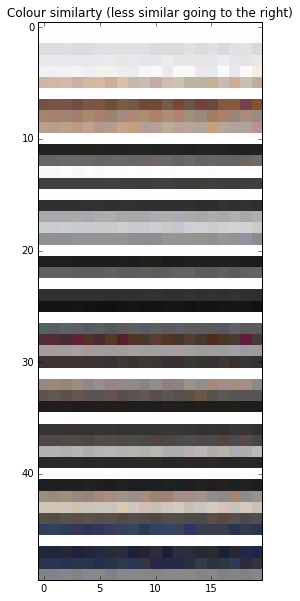

In [20]:
p = flat_features[ix].reshape(50, 20, 3)
f, ax = pyplot.subplots(1)
f.set_size_inches(10, 10)
ax.set_title('Colour similarty (less similar going to the right)')
_ = ax.imshow(p / p.max(), interpolation='nearest')

Now we have:
* A feature extractor (k-means clustering)
* A feature index (nearest-neighbours)

The third and last step is to rank the results. Ranking is a complex subject in itself. We're going to use a stupidly simple ranker to illustrate the point.

In [24]:
# Cluster all colours to allow determining an inverse document frequency.
idf_kmeans = cluster.MiniBatchKMeans(60).fit(flat_features)
tf_idf_df = pandas.DataFrame()
tf_idf_df


""


In [25]:
tf_idf_df['idf_count'] = idf_kmeans.counts_[idf_kmeans.labels_]
tf_idf_df['idf'] = numpy.log(len(tf_idf_df) / tf_idf_df['idf_count'])
tf_idf_df['tf'] = 5

In [27]:
def rank(colours, tf_idf_df, nns):
    # Find some candidates (10 per colour)
    distances, ix  = nns.kneighbors(colours, 10)
    candidate_df = pandas.DataFrame(
        dict(colour_distance=distances.flatten()), 
        index=ix.flatten(),
    )
    result = tf_idf_df.join(candidate_df)
    # The following line decides the rank. Tuning and augmenting 
    # it with additional data can vastly improve results. 
    result['rank'] = result['colour_distance'] / (result['idf'] * result['tf'] )
    return result.sort('rank').dropna()    

In [28]:
ranked = rank(flat_features[5*21:5*21+5], tf_idf_df, nns)
ranked.head(10)[5:]

/Users/peadarcoyle/anaconda/envs/sea/lib/python3.4/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,idf_count,idf,tf,colour_distance,rank
1585,469,1.385761,5,0.044815,0.006468
240,469,1.385761,5,0.053327,0.007696
1590,469,1.385761,5,0.066104,0.009540
1700,435,1.461018,5,0.101723,0.013925
1355,469,1.385761,5,0.114522,0.016528


/Users/peadarcoyle/anaconda/envs/sea/lib/python3.4/site-packages/ipykernel/__main__.py:4: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


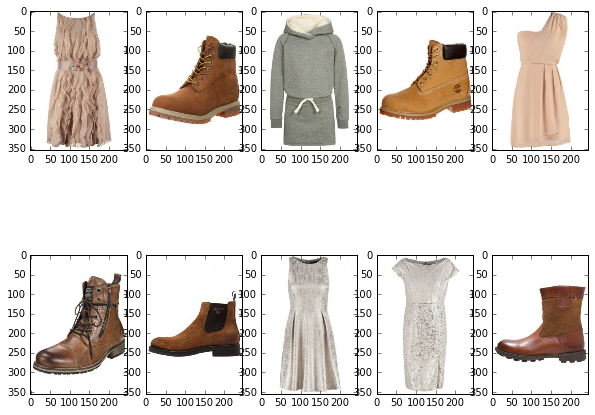

In [33]:
f, ax = pyplot.subplots(2, 5)
f.set_size_inches(10, 8)
for i, ax_ in enumerate(ax.ravel()):
    ax_.imshow(im[ranked.irow(i + 4).name // 5]) # +4 because the first 5 items are perfect matchs.

We can see that this isn't perfect but it's already returning the cream-like and the darkish colours of the reference image (top left). The core algorithm now is:
1. Feature extraction
2. Indexing
3. Ranking

There is a lot of room for improvement in this simple pipeline. A few obvious choices are a better ranker or transforming to perception-friendly colour spaces like HSV. The three steps will stay the same though.